# Visualization of Results

Here we have the code to create all of the plots and tables used in the paper.

For the plots of the SRBench Testsuite, please refer to https://github.com/cavalab/srbench with the dataframe stored in `results/ground-truth_results_new.feather`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import sympy
import pickle
from sklearn.metrics import r2_score


from DAG_search import utils
from DAG_search import dag_search
from DAG_search import comp_graph

from regressors import regressors

## Table: Influence of parameter $p$

Example:
\begin{align}
\frac{1}{3}x^2
\end{align}

In [16]:
# define regression problem
np.random.seed(0)
true_model = sympy.sympify('(x_0^2)/3')
X = np.random.rand(100, 1)
y = (X[:, 0]**2)/3

n_params = [0, 1, 2]
n_intermediary = [0, 1, 2, 3]

res_dict = {} # access via [p][i]


scores = []
models = []

for k in n_params:
    res_dict[k] = {}
    for c in n_intermediary:
        print(f'n_params: {k}, intermediary: {c}')
        est = dag_search.DAGRegressor(n_calc_nodes = c, k = k, max_orders = int(1e4), random_state = 0)
        est.fit(X, y, verbose = 0)
        mse = np.mean((est.predict(X) - y)**2)
        model = str(est.model())
        rec = utils.symb_eq(est.model(), true_model)
        
        res_dict[k][c] = {
            'MSE' : mse,
            'model' : model,
            'recovery' : rec
        }
        

n_params: 0, intermediary: 0
n_params: 0, intermediary: 1
n_params: 0, intermediary: 2
n_params: 0, intermediary: 3
n_params: 1, intermediary: 0
n_params: 1, intermediary: 1
n_params: 1, intermediary: 2
n_params: 1, intermediary: 3
n_params: 2, intermediary: 0
n_params: 2, intermediary: 1
n_params: 2, intermediary: 2
n_params: 2, intermediary: 3


In [17]:
# print a table
#crit = 'recovery'
crit = 'MSE'

# header
s = '\\begin{tabular}{l' + 'c'*len(n_intermediary) + '}'
print(s)
s = '$p$/$i$'
for i in n_intermediary:
    s += f'&{i}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for k in n_params:
    s = str(k)
    for c in n_intermediary:
        if crit in res_dict[k][c]:
            v = res_dict[k][c][crit]
            if 'MSE' in crit:
                v = np.round(v, 4)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{lcccc}
$p$/$i$&0&1&2&3\\
\toprule
0&0.0197&0.0073&0.0002&0.0\\
1&0.0013&0.0&0.0&0.0\\
2&0.0013&0.0&0.0&0.0\\
\end{tabular}


## Figure: Size of Sample Space

In [107]:
def get_n_frames(inp_nodes, inter_nodes):
    I = inp_nodes
    n = inter_nodes
    ret = I*(I + n + 1)
    for i in range(n):
        ret = ret * (I + (i+1))**2
    return ret

0 6
1 72
2 1440
3 43200
4 1814400
5 101606400
6 7315660800
7 658409472000
8 72425041920000
9 9560105533440000


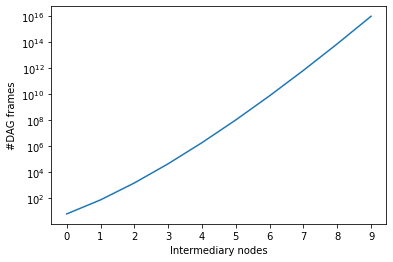

In [108]:
# 1. fix input nodes, vary intermediate nodes
inp_nodes = 2

xs = []
n_frames = []

for i in range(0, 10):
    frames = get_n_frames(inp_nodes, i)
    print(i, frames)
    xs.append(i)
    n_frames.append(frames)
    
    
plt.yscale('log')
plt.ylabel('#DAG frames')
plt.xlabel('Intermediary nodes')
plt.xticks(xs)
plt.plot(xs, n_frames)
plt.savefig(f'results/figures/dagframes_intermediate.pdf', bbox_inches = 'tight')

1 12
2 72
3 240
4 600
5 1260
6 2352
7 4032
8 6480
9 9900


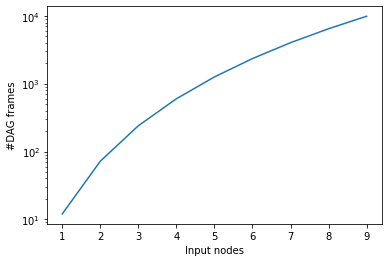

In [109]:
# 1. vary input nodes, fix intermediate nodes

inter_nodes = 1

xs = []
n_frames = []

for i in range(1, 10):
    frames = get_n_frames(i, inter_nodes)
    print(i, frames)
    xs.append(i)
    n_frames.append(frames)
    
    
plt.yscale('log')
plt.ylabel('#DAG frames')
plt.xlabel('Input nodes')
plt.xticks(xs)
plt.plot(xs, n_frames)
plt.savefig(f'results/figures/dagframes_input.pdf', bbox_inches = 'tight')

## Nguyen-6

In [2]:
ds_name = 'Nguyen'
problem_name = 'Nguyen-6'

load_path = f'results/{ds_name}/{problem_name}_dagframes.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)

In [3]:
[len(res_dict[x]) for x in res_dict]

[100, 100, 100, 100, 100, 97]

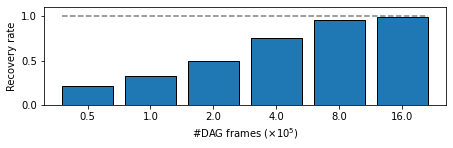

In [4]:
orders = sorted(list(res_dict.keys()))
avgs = []
lowers = []
uppers = []
for o in orders:
    avg, lower, upper = dag_search.utils.mean_confidence_interval(res_dict[o])
    avgs.append(avg)
    lowers.append(lower)
    uppers.append(upper)
#plt.fill_between(range(len(avgs)), lowers, uppers, color = 'tab:blue', alpha = 0.5)
fs = 1.2
fig = plt.figure(figsize = (len(avgs)*fs, 1.5*fs))
plt.bar(range(len(avgs)), avgs, edgecolor='black') # barplot
plt.xlabel('#DAG frames ' + r'$(\times 10^5)$')
plt.ylabel('Recovery rate')

round_orders = [o/int(10**5) for o in orders]
plt.xticks(range(len(avgs)), round_orders)
plt.ylim(0.0, 1.1)

# plot dotted line
tmp = [p.get_width() for p in plt.gca().patches]
plt.plot([0-tmp[0]/2, len(avgs)-1 + tmp[-1]/2], [1, 1], color = 'gray', linestyle = '--')

plt.savefig(f'results/figures/dagframes_{problem_name}.pdf', bbox_inches = 'tight')

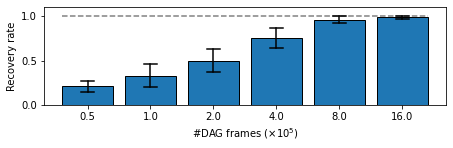

In [5]:
# transform to list of averages
import math
k = 10 # population size
avg_dict = {}
for n_orders in res_dict:
    avgs = []
    recs = res_dict[n_orders]
    n_its = math.ceil(len(recs)/k)
    for i in range(n_its):
        sl = recs[i*k:(i+1)*k]
        avgs.append(np.mean(sl))
    avg_dict[n_orders] = avgs
    
# plot bars
orders = sorted(list(avg_dict.keys()))
avgs = []
lowers = []
uppers = []
for o in orders:
    avg, lower, upper = dag_search.utils.mean_confidence_interval(avg_dict[o])
    avgs.append(avg)
    lowers.append(max(0.0, lower))
    uppers.append(min(1.0, upper))
fs = 1.2
fig = plt.figure(figsize = (len(avgs)*fs, 1.5*fs))
plt.bar(range(len(avgs)), avgs, edgecolor='black') # barplot
plt.xlabel('#DAG frames ' + r'$(\times 10^5)$')
plt.ylabel('Recovery rate')

round_orders = [o/int(10**5) for o in orders]
plt.xticks(range(len(avgs)), round_orders)
plt.ylim(0.0, 1.1)

# plot dotted line
tmp = [p.get_width() for p in plt.gca().patches]
plt.plot([0-tmp[0]/2, len(avgs)-1 + tmp[-1]/2], [1, 1], color = 'gray', linestyle = '--')

# plot confidence intervals
k = tmp[0]/8
c = 'black'
for i in range(len(avgs)):
    plt.plot([i, i], [lowers[i], uppers[i]], color = c, linestyle = '-')
    plt.plot([i-k, i+k], [lowers[i], lowers[i]], color = c, linestyle = '-')
    plt.plot([i-k, i+k], [uppers[i], uppers[i]], color = c, linestyle = '-')
    

plt.savefig(f'results/figures/dagframes_{problem_name}_ci.pdf', bbox_inches = 'tight')

## Examples for partial recovery

In [6]:
ds_name = 'Feynman'
regressor_name = 'DAGSearchPoly'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path = f'results/{ds_name}/{regressor_name}_results.p'
with open(load_path, 'rb') as handle:
    results_dict = pickle.load(handle)

Soft measure of recovery:

- $S_i$... set of simplified subexpressions for expression $e_i$

Jaccard-Index
\begin{align}
J(S_0, S_1) = \cfrac{|S_0\cap S_1|}{|S_0\cup S_1|}
\end{align}

- $J\in [0, 1]$ 
- $J = 1$ if $S_0 = S_1$

In [7]:
jaccard_idxs = []
recs = []
problems = []
for problem_name in results_dict.keys():
    expr_est = results_dict[problem_name]['exprs'][0]
    expr_true = task_dict[problem_name]['expr'][0]
    ji = utils.jaccard_idx(expr_est, expr_true)
    rec = results_dict[problem_name]['recovery'][0]
    print(problem_name, rec, ji)
    jaccard_idxs.append(ji)
    recs.append(int(rec))
    problems.append(problem_name)
jaccard_idxs = np.array(jaccard_idxs)
recs = np.array(recs)

I.10.7 False 0.2727272727272727
I.11.19 True 1.0
I.12.1 True 1.0
I.12.11 True 1.0
I.12.2 True 1.0
I.12.4 True 1.0
I.12.5 True 1.0
I.13.12 True 1.0
I.13.4 False 0.23529411764705882
I.14.3 True 1.0
I.14.4 True 1.0
I.15.3t False 0.14814814814814814
I.15.3x False 0.5238095238095238
I.16.6 True 1.0
I.18.12 True 1.0
I.18.14 True 1.0
I.18.4 True 1.0
I.24.6 False 0.22727272727272727
I.25.13 True 1.0
I.27.6 True 1.0
I.29.16 False 0.37037037037037035
I.29.4 True 1.0
I.30.3 False 0.12
I.32.17 False 0.26666666666666666
I.32.5 True 1.0
I.34.1 True 1.0
I.34.14 False 0.18518518518518517
I.34.27 True 1.0
I.34.8 True 1.0
I.37.4 True 0.42857142857142855
I.38.12 True 1.0
I.39.1 True 1.0
I.39.11 True 1.0
I.39.22 True 1.0
I.40.1 False 0.4117647058823529
I.41.16 False 0.26666666666666666
I.43.16 True 1.0
I.43.31 True 1.0
I.43.43 True 1.0
I.44.4 False 0.3888888888888889
I.47.23 True 0.3076923076923077
I.50.26 False 0.46153846153846156
I.6.2 False 0.19047619047619047
I.6.2a True 1.0
I.6.2b False 0.31818181818

In [8]:
values = np.maximum(recs, jaccard_idxs)
sort_idx = np.argsort(jaccard_idxs)
for i in sort_idx:
    print(problems[i], jaccard_idxs[i])

I.30.3 0.12
II.11.28 0.13636363636363635
I.15.3t 0.14814814814814814
III.4.33 0.16
II.13.34 0.16666666666666666
I.34.14 0.18518518518518517
I.6.2 0.19047619047619047
II.13.23 0.20833333333333334
II.24.17 0.2222222222222222
I.24.6 0.22727272727272727
I.9.18 0.23333333333333334
I.13.4 0.23529411764705882
III.4.32 0.25
III.14.14 0.2608695652173913
I.32.17 0.26666666666666666
I.41.16 0.26666666666666666
III.10.19 0.26666666666666666
I.10.7 0.2727272727272727
II.6.15a 0.2916666666666667
II.11.27 0.29411764705882354
III.8.54 0.3
I.47.23 0.3076923076923077
II.35.21 0.3157894736842105
I.6.2b 0.3181818181818182
II.36.38 0.3181818181818182
II.11.3 0.35
III.9.52 0.35714285714285715
I.29.16 0.37037037037037035
I.44.4 0.3888888888888889
I.40.1 0.4117647058823529
I.8.14 0.4166666666666667
I.37.4 0.42857142857142855
I.50.26 0.46153846153846156
II.6.11 0.4666666666666667
II.35.18 0.5
I.15.3x 0.5238095238095238
II.38.14 0.6
II.6.15b 0.7333333333333333
II.38.3 1.0
II.37.1 1.0
I.12.5 1.0
II.4.23 1.0
I.13

In [9]:
problem_name = 'II.6.11'
expr_est = results_dict[problem_name]['exprs'][0]
expr_true = task_dict[problem_name]['expr'][0]
expr_est, expr_true

(0.09577*x_1*cos(x_2)/(x_0**(3/2)*x_3**2), x_1*cos(x_2)/(4*pi*x_0*x_3**2))

In [10]:
utils.jaccard_idx(expr_est, expr_true)

0.4666666666666667

## Comparison to ESR

Takeaway: Our Approach is better than ESR (in all Aspects)

In [113]:
import pickle
regs = ['esr', 'DAGSearch', 'DAGSearchPoly']
ds_name = 'Univ' # Strogatz, Feynman, Nguyen, Univ  

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
# collect results
from sklearn.metrics import r2_score
res = {}
for regressor_name in regs:
    load_path = f'results/{ds_name}/{regressor_name}_results.p'
    if os.path.exists(load_path):
        res[regressor_name] = {}
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)

        # avg. recovery
        recoveries = []
        for problem in results_dict.keys():
            #for rec in results_dict[problem]['recovery']:
            #    recoveries.append(rec)
            for y, pred, rec in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test'], results_dict[problem]['recovery']):
                r2 = r2_score(y, pred)
                recoveries.append(rec or r2==1.0)
        res[regressor_name]['recovery'] = np.mean(recoveries)


        # avg. RMSE
        rmses_train = []
        rmses_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_train.append(rmse)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_test.append(rmse)
        res[regressor_name]['rmse_train'] = np.mean(rmses_train)
        res[regressor_name]['rmse_test'] = np.mean(rmses_test)

        # median R2
        r2s_train = []
        r2s_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                r2 = r2_score(y, pred)
                r2s_train.append(r2)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                r2 = r2_score(y, pred)
                r2s_test.append(r2)
        res[regressor_name]['r2_train'] = np.median(r2s_train)
        res[regressor_name]['r2_test'] = np.median(r2s_test)
            
        # expression size
        expr_sizes = []
        for problem in results_dict.keys():
            for expr in results_dict[problem]['exprs']:
                expr_sizes.append(utils.tree_size(expr))
        if len(expr_sizes) > 0:
            res[regressor_name]['complexity'] = np.mean(expr_sizes)
            
        # processing times
        time = 0.0
        counter = 0
        for problem in results_dict.keys():
            for t in results_dict[problem]['times']:
                time += t
                counter += 1
        time = time/counter
        
        res[regressor_name]['time'] = time

In [114]:
# Make Table
reg_names = {
    'esr' : 'ESR',
    'DAGSearch' : 'USDF',
    'DAGSearchPoly' : 'USDF + Aug'
}

crit_names = {
    'recovery' : 'Rec',
    #'rmse_train' : 'RMSE Train',
    #'rmse_test' : 'RMSE Test',
    #'r2_train' : '$R^2$ Train',
    'r2_test' : '$R^2$',
    'complexity' : 'Complexity',
    'time' : 'Time'
}

# print a table
regs = list(res.keys())
crits = list(crit_names.keys())
sort_idx = np.argsort([-res[reg]['recovery'] for reg in regs])
regs = [regs[i] for i in sort_idx]

# header
s = '\\begin{tabular}{l' + 'c'*len(crits) + '}'
print(s)
s = ''
for crit in crits:
    s += f'&{crit_names[crit]}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for reg in regs:
    s = reg_names[reg]
    for crit in crits:
        if crit in res[reg]:
            v = res[reg][crit]
            if 'r2' in crit:
                v = np.round(v, 2)
            else:
                v = np.round(v, 2)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{lcccc}
&Rec&$R^2$&Complexity&Time\\
\toprule
USDF + Aug&1.0&1.0&9.3&26.12\\
USDF&0.8&1.0&9.4&388.82\\
ESR&0.5&1.0&9.7&1293.63\\
\end{tabular}


## Timing

Takeaway: Our Approach is highly parallelizable

In [115]:
ds_names = ['Univ', 'Nguyen', 'Feynman', 'Strogatz']

results = {}

for ds_name in ds_names:
    load_path = f'datasets/{ds_name}/tasks.p'
    with open(load_path, 'rb') as handle:
        task_dict = pickle.load(handle)

    load_path = f'results/{ds_name}/timings.p'
    if os.path.exists(load_path):
        with open(load_path, 'rb') as handle:
            res_dict = pickle.load(handle)

        problems = list(res_dict.keys())
        n_processes = sorted(list(res_dict[problems[0]].keys()))
        # res_dict[problem][n_processes] = all_times
        # collect average times per number of processes

        avg_times = []
        for n_p in n_processes:
            times = []
            for problem in problems:
                if n_p in res_dict[problem]:
                    times.append(np.mean(res_dict[problem][n_p]))
            avg_times.append(np.mean(times))

        
        results[ds_name] = {}
        for n_p, t in zip(n_processes, avg_times):
            results[ds_name][n_p] = t

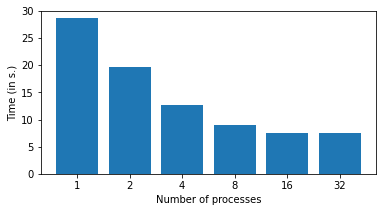

In [116]:
ds_name = 'Feynman'
fig = plt.figure(figsize = (6, 3))
cores = sorted(list(results[ds_name].keys()))
times = [results[ds_name][c] for c in cores]
plt.bar(range(len(cores)), times)
plt.xticks(range(len(cores)), cores)
plt.xlabel('Number of processes')
plt.ylabel('Time (in s.)')
plt.savefig(f'results/figures/times_{ds_name}.pdf', bbox_inches = 'tight')

In [117]:
# print table
ds_name = 'Feynman'
n_round = 2
cores = sorted(list(results[ds_name].keys()))
times = [results[ds_name][c] for c in cores]

# header
s = '\\begin{tabular}{l' + 'c'*len(cores) + '}'
print(s)


s = 'Processes'
for c in cores:
    v = c
    s += f'&{v}'
s += '\\\\'
print(s)
print('\\midrule')


s = 'Time (in s.)'
for t in times:
    v = np.round(t, n_round)
    s += f'&{v}'
s += '\\\\'
print(s)

s = '\\end{tabular}'
print(s)

\begin{tabular}{lcccccc}
Processes&1&2&4&8&16&32\\
\midrule
Time (in s.)&28.61&19.68&12.63&8.92&7.46&7.58\\
\end{tabular}


## Scalability

Takeaway: Our Approach has potential to scale with

- number of calculation nodes (= max size of expression)
- number of orders (= coverage)

In [21]:
ds_name = 'Feynman'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path = f'results/{ds_name}/scalings.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)

seeds = sorted(list(res_dict.keys()))
nodes = sorted(list(res_dict[seeds[0]].keys()))
orders = sorted(list(res_dict[seeds[0]][nodes[0]].keys()))
problems = list(task_dict.keys())

# average results for each seed 
# how to access: [rand_state][n_calc_nodes][max_orders][problem]

recovery_results = {}
time_results = {}
for n_calc_nodes in nodes:
    recovery_results[n_calc_nodes] = {}
    time_results[n_calc_nodes] = {}
    
    for max_orders in orders:
        all_recs = []
        all_times = []
        for seed in seeds:
            recs = []
            times = []
            
            if (n_calc_nodes in res_dict[seed]) and (max_orders in res_dict[seed][n_calc_nodes]):  
                #for problem in res_dict[seed][n_calc_nodes][max_orders]:
                for problem in res_dict[seed][n_calc_nodes][max_orders]:
                    recs += res_dict[seed][n_calc_nodes][max_orders][problem]['recovery']
                    times += res_dict[seed][n_calc_nodes][max_orders][problem]['times']
                avg_rec = np.mean(recs)
                avg_time = np.mean(times)

                all_recs.append(avg_rec)
                all_times.append(avg_time)
        # here we have lists with avg results for each seed    
        
        if len(all_recs) > 0:
        
            recovery_results[n_calc_nodes][max_orders] = np.mean(all_recs)
            time_results[n_calc_nodes][max_orders] = np.mean(all_times)

In [22]:
# print table
#table_data, n_round = recovery_results, 2
table_data, n_round = time_results, 1


# header
s = '\\begin{tabular}{c' + 'l'*len(orders) + '}'
print(s)

s = '$i$/$d$' # insert diag cell here
for o in orders:
    v = o//(10**3)
    s += f'&{v}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for n_calc_nodes in nodes:
    s = str(n_calc_nodes)
    for o in orders:
        if n_calc_nodes in table_data:
            if o in table_data[n_calc_nodes]:
                v = np.round(table_data[n_calc_nodes][o], n_round)
                if n_round == 0:
                    v = int(v)
                s += f'&{v}'
                  
            else:
                s += '&-'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{cllll}
N/F&10&20&40&80\\
\toprule
1&5.4&5.5&5.8&5.9\\
2&7.4&7.7&9.3&10.8\\
3&8.9&12.4&17.4&27.6\\
4&15.1&20.7&27.9&43.8\\
\end{tabular}


## Figure: We solve all small Problems

In [99]:
ds_name = 'Nguyen'
#regressor = 'DAGSearch'
regressor = 'DAGSearchPoly'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path = f'results/{ds_name}/{regressor}_results.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)


In [100]:
problems = res_dict.keys()

problem_sizes = []
recs = []
problem_names = []
for problem in problems:
    r = res_dict[problem]['recovery']
    for i in range(len(r)):
        recs.append(r[i])
        expr = task_dict[problem]['expr'][i]
        problem_sizes.append(utils.tree_size(expr))
        if len(r) > 1:
            problem_names.append(f'{problem}_{i}')
        else:
            problem_names.append(f'{problem}')

In [101]:
sort_idx = np.argsort(problem_sizes)
problem_sizes = [problem_sizes[i] for i in sort_idx]
problem_names = [problem_names[i] for i in sort_idx]
recs = [recs[i] for i in sort_idx]

rec_idxs = [i for i in range(len(recs)) if recs[i]]
not_rec_idxs = [i for i in range(len(recs)) if not recs[i]]

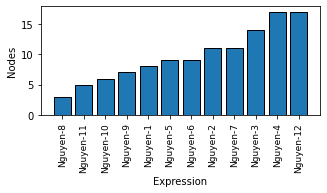

In [102]:
#fig = plt.figure(figsize = (15, 2)) # for feynman
fig = plt.figure(figsize = (5, 2))
# 1. plot recovered problems
plt.bar(rec_idxs, [problem_sizes[i] for i in rec_idxs], color = 'tab:blue', edgecolor = 'black')

# 2. plot not recovered problems
plt.bar(not_rec_idxs, [problem_sizes[i] for i in not_rec_idxs], color = 'tab:gray', edgecolor = 'black')

# 3. add legend
plt.scatter([], [], color = 'tab:blue', label = 'recovered')
plt.scatter([], [], color = 'tab:gray', label = 'not recovered')
#plt.legend()


# 4. add writing
plt.xticks(range(len(recs)), problem_names, rotation = 90)
plt.gca().tick_params(axis='x', which='major', labelsize=9)
plt.ylabel('Nodes')
plt.xlabel('Expression')
#plt.title(f'{regressor} - {ds_name}')
plt.savefig(f'results/figures/problem_sizes_{ds_name}_{regressor}.pdf', bbox_inches = 'tight')
plt.show()

In [103]:
# for paper: two plots next to each other 

ds_name = 'Nguyen'
regressor1 = 'DAGSearch'
regressor2 = 'DAGSearchPoly'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path1 = f'results/{ds_name}/{regressor1}_results.p'
with open(load_path1, 'rb') as handle:
    res_dict1 = pickle.load(handle)
    
load_path2 = f'results/{ds_name}/{regressor2}_results.p'
with open(load_path2, 'rb') as handle:
    res_dict2 = pickle.load(handle)

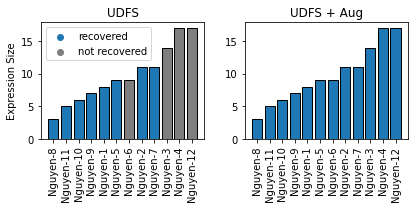

In [105]:
problems = res_dict1.keys()

problem_sizes = []
recs1 = []
recs2 = []
problem_names = []
for problem in problems:
    r1 = res_dict1[problem]['recovery']
    r2 = res_dict2[problem]['recovery']
    for i in range(len(r1)):
        recs1.append(r1[i])
        recs2.append(r2[i])
        expr = task_dict[problem]['expr'][i]
        problem_sizes.append(utils.tree_size(expr))
        if len(r1) > 1:
            problem_names.append(f'{problem}_{i}')
        else:
            problem_names.append(f'{problem}')
            
sort_idx = np.argsort(problem_sizes)
problem_sizes = [problem_sizes[i] for i in sort_idx]
problem_names = [problem_names[i] for i in sort_idx]
recs1 = [recs1[i] for i in sort_idx]
recs2 = [recs2[i] for i in sort_idx]

rec_idxs1 = [i for i in range(len(recs1)) if recs1[i]]
not_rec_idxs1 = [i for i in range(len(recs1)) if not recs1[i]]
rec_idxs2 = [i for i in range(len(recs2)) if recs2[i]]
not_rec_idxs2 = [i for i in range(len(recs2)) if not recs2[i]]


fs = 3.0
fig, axs = plt.subplots(ncols = 2, figsize = (2*fs, fs))


for i, (rec_idxs, not_rec_idxs, title) in enumerate([(rec_idxs1, not_rec_idxs1, 'UDFS'), (rec_idxs2, not_rec_idxs2, 'UDFS + Aug')]):
    # 1. plot recovered problems
    axs[i].bar(rec_idxs, [problem_sizes[i] for i in rec_idxs], color = 'tab:blue', edgecolor = 'black')

    # 2. plot not recovered problems
    axs[i].bar(not_rec_idxs, [problem_sizes[i] for i in not_rec_idxs], color = 'tab:gray', edgecolor = 'black')

    # 4. add writing
    axs[i].set_xticks(range(len(recs1)), problem_names, rotation = 90)
    #axs[i].tick_params(axis='x', which='major', labelsize=9)
    if i == 0:
        axs[i].set_ylabel('Expression Size')
        
    axs[i].set_title(title)
    #axs[i].set_xlabel('Expression')

# 3. add legend
axs[0].scatter([], [], color = 'tab:blue', label = 'recovered')
axs[0].scatter([], [], color = 'tab:gray', label = 'not recovered')
axs[0].legend()

plt.tight_layout()

#plt.title(f'{regressor} - {ds_name}')
plt.savefig(f'results/figures/problem_sizes_{ds_name}.pdf', bbox_inches = 'tight')
plt.show()

## Figure: Flowchart

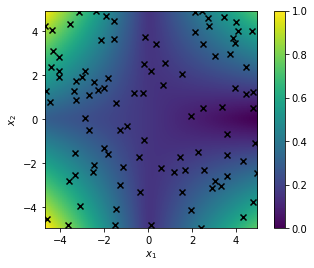

In [63]:
def func(x0, x1):
    return np.sqrt((x0*x1)**2 + 1) - x0

X = np.random.rand(100, 2)*10-5
y = func(X[:, 0], X[:, 1])

# Set up a regular grid of interpolation points
x0, x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x0, x1 = np.meshgrid(x0, x1)
ys = func(x0, x1)


plt.imshow(ys, vmin=ys.min(), vmax=ys.max(), origin='lower',extent=[X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()])
#plt.scatter(x, y, c=z)

plt.scatter(X[:, 0], X[:, 1], color = 'black', marker = 'x')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.colorbar()
plt.savefig(f'results/figures/workflow1.pdf', bbox_inches = 'tight')

## Figure: Hierarchical Grid Search

In [149]:
# true expression: (x + c)**2
node_dict = {
    0 : ([], 'inp'), # x
    1 : ([], 'const'), # c
    2 : ([3], 'sq'), # (x+c)**2
    3 : ([0, 1], 'sub_l'), # x+c
}
graph = comp_graph.CompGraph(m = 1, n = 1, k = 1, node_dict = node_dict)
graph.evaluate_symbolic()

[(-c_0 + x_0)**2]

In [243]:
X = np.random.rand(100, 1)*5-2.5
y = (X[:, 0] - np.sqrt(2))**2

loss_fkt = dag_search.MSE_loss_fkt(y)

In [244]:
interval_upper, interval_lower = 2, 1
n_steps = 8
n_zooms = 3

all_losses = []
all_c = []
all_loss = []
all_values = []


k = graph.n_consts
interval_size = interval_upper - interval_lower
c = (interval_upper + interval_lower)/2*np.ones(k)
stepsize = interval_size/(n_steps - 1)
for zoom in range(n_zooms):
    c_init = c

    c_init = c_init*np.ones(k)

    l = interval_size/2
    values = np.linspace(-l, l, n_steps)
    tmp = np.meshgrid(*[values]*k)
    consts = np.column_stack([x.flatten() for x in tmp])
    consts = consts + np.stack([c_init]*len(consts))

    losses = loss_fkt(X, graph, consts)
    
    

    best_idx = np.argmin(losses)
    c = consts[best_idx]
    loss = losses[best_idx]
    
    print(c[0], loss)
    
    all_losses.append(losses)
    all_c.append(c[0])
    all_loss.append(loss)
    all_values.append(consts[:, 0])
    
    interval_size = 2*stepsize
    stepsize = interval_size/(n_steps - 1)



1.4285714285714286 0.003376192800870981
1.4081632653061225 0.0005951642993750463
1.41399416909621 7.84213261392799e-07


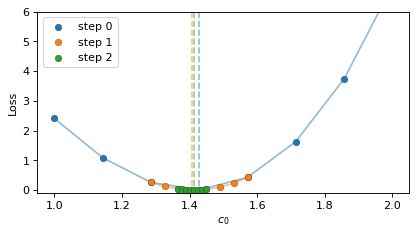

In [256]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
min_v = 0.0
max_v = 6
fig = plt.figure(figsize=(6, 3), dpi=80)

for i, (values, losses) in enumerate(zip(all_values, all_losses)):
    c = colors[i%len(all_values)]
    plt.plot(values, losses, color = c, alpha = 0.5)
    plt.scatter(values, losses, color = c, linewidth = 0.2, zorder = 2, edgecolor='black', label = f'step {i}')
    min_c = values[np.argmin(losses)]
    
    
    plt.plot([min_c, min_c], [max_v, min_v], color = c, linestyle = '--', alpha = 0.5)
    
#plt.plot([np.pi, np.pi], [max_v, min_v], color = 'black', linestyle = '--', alpha = 0.5)
plt.ylim((min_v - 0.1, max_v))
plt.legend()
plt.xlabel(r'$c_0$')
plt.ylabel('Loss')
plt.savefig(f'results/figures/grid_search_example.pdf', bbox_inches = 'tight')

## Damped Pendulum

$y(t)=e^{-t}\cos(2\pi t)$

In [118]:
np.random.seed(0)
x_values = np.linspace(0, 0.75, 1000).reshape(-1, 1)
X = np.linspace(0, 0.75, 10).reshape(-1, 1)
y = np.exp(-X[:, 0])*np.cos(2*np.pi*X[:, 0])

In [119]:
from regressors import regressors
regr = regressors.PolyReg(4)
regr.fit(X, y)
pred_poly = regr.predict(x_values)

pred_symb = np.exp(-x_values[:, 0])*np.cos(6*x_values[:, 0])
pred_decay = np.exp(-x_values[:, 0])
pred_oscillation = np.cos(6*x_values[:, 0])

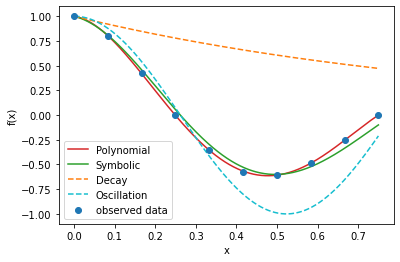

In [123]:
plt.plot(x_values, pred_poly, color ='tab:red', label = 'Polynomial')
plt.plot(x_values, pred_symb, color ='tab:green', label = 'Symbolic')
plt.plot(x_values, pred_decay, color ='tab:orange', label = 'Decay', linestyle = '--')
plt.plot(x_values, pred_oscillation, color ='tab:cyan', label = 'Oscillation', linestyle = '--')
plt.scatter(X, y, color = 'tab:blue', label = 'observed data', zorder = 2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

plt.savefig(f'results/figures/intro_example.pdf', bbox_inches = 'tight')

In [124]:
regr.model()

-34.4572579935495*x_0**4 + 60.3564758586689*x_0**3 - 27.0078906836237*x_0**2 - 0.489063145387913*x_0 + 0.998021329322976

# !!Not used!!

## Price Theorem does not hold here

If occurence of a Trait in population correlates positively with fitness of population, it will occur more often.

Here: Track fitness of population and occurences of traits of target expression

Trait = Subexpression

In [141]:
ds_name = 'Feynman'

load_path = f'results/{ds_name}/covariances.p'
with open(load_path, 'rb') as handle:
    results_dict = pickle.load(handle)

In [142]:
problems = list(results_dict.keys())
nmb_traits = np.array([len(results_dict[problem_name]['covariances']) for problem_name in results_dict])
max_traits = max(nmb_traits)


sort_idx = np.argsort(-nmb_traits)
problems = [problems[i] for i in sort_idx]

disp_matrix = -np.ones((max_traits, len(results_dict)))

for i, problem in enumerate(problems):
    covs = results_dict[problem]['covariances']
    disp_matrix[:len(covs), i] = covs

Text(0.5, 1.0, 'Feynman')

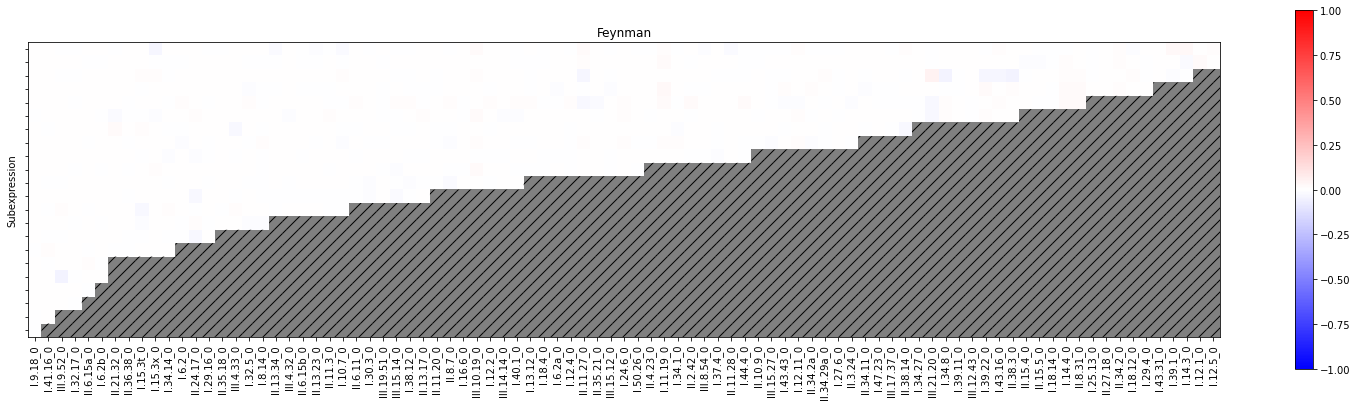

In [143]:
fs = 0.3
plt.figure(figsize = (len(problems)*fs, max_traits*fs))
plt.imshow(disp_matrix, cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()

# add gray hatched area
tmp_img = (disp_matrix == -1).astype(float)
tmp_img[tmp_img == 0] = np.nan
mask = ~np.isnan(tmp_img)
tmp_img[mask] = 0.5
plt.imshow(tmp_img, cmap = 'gray', vmin = 0.0, vmax = 1.0)
zm = np.ma.masked_where(~mask, tmp_img)
plt.pcolor(np.arange(len(problems)), np.arange(max_traits), zm, hatch='//', alpha=0.0)

plt.xticks(range(len(problems)), problems, rotation = 90)
plt.yticks(range(max_traits), [])
plt.ylabel('Subexpression')
plt.title(ds_name)

## Local Minima

For a problem:
- sample population
- connect expressions with edit distance 1
- identify local minima in this population (= all neighbours are worse) 

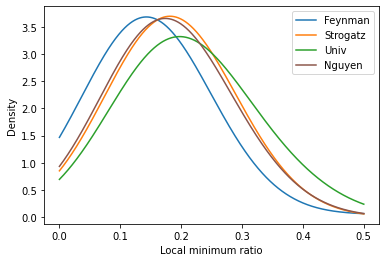

In [145]:
# estimate density
from sklearn.neighbors import KernelDensity
ds_names = ['Feynman', 'Strogatz', 'Univ', 'Nguyen']
ds_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

x_values = np.linspace(0, 0.5, 1000).reshape(-1, 1)

for ds_name, ds_color in zip(ds_names, ds_colors):

    load_path = f'results/{ds_name}/local_minima.p'
    if os.path.exists(load_path):
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)
            
        ratios = np.array([results_dict[p] for p in results_dict])
        kde = KernelDensity(kernel='gaussian', bandwidth = 0.1).fit(ratios.reshape(-1, 1))
        log_densities = kde.score_samples(x_values)

        plt.plot(x_values, np.exp(log_densities), color = ds_color, label = ds_name)


plt.xlabel('Local minimum ratio')
plt.ylabel('Density')
plt.legend()

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/local_minima.pdf', bbox_inches = 'tight')

## Fitness Distance Correlation

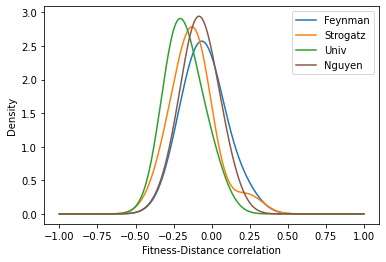

In [368]:
# estimate density
from sklearn.neighbors import KernelDensity
ds_names = ['Feynman', 'Strogatz', 'Univ', 'Nguyen']
ds_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

x_values = np.linspace(-1, 1, 1000).reshape(-1, 1)

for ds_name, ds_color in zip(ds_names, ds_colors):

    load_path = f'results/{ds_name}/fdc.p'
    with open(load_path, 'rb') as handle:
        results_dict = pickle.load(handle)
    fdcs = np.array([results_dict[p] for p in results_dict])
    kde = KernelDensity(kernel='gaussian', bandwidth = 0.1).fit(fdcs.reshape(-1, 1))
    log_densities = kde.score_samples(x_values)
    
    plt.plot(x_values, np.exp(log_densities), color = ds_color, label = ds_name)


plt.xlabel('Fitness-Distance correlation')
plt.ylabel('Density')
plt.legend()

## Experiment: local minima

Takeaway: Local Search does not work, because we have lots of local minima.

In [71]:
load_path = 'results/local_minima_exp.p'
with open(load_path, 'rb') as handle:
    results = pickle.load(handle)

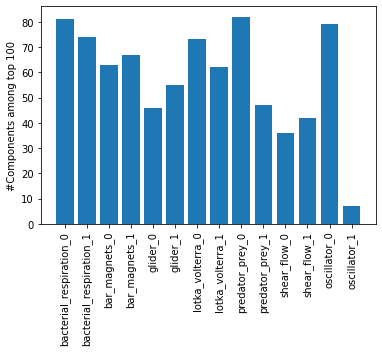

In [72]:
names = list(results.keys())
values = [results[n]['groups'] for n in names]
plt.bar(range(len(names)), values)
plt.xticks(range(len(names)), names, rotation = 90)
plt.ylabel(f'#Components among top {results[names[0]]["topk"]}')

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/local_minima.pdf', bbox_inches = 'tight')

## Experiment: Black Box vs. Symbolic

Takeaway: If you care about model fit, use Black Box. 

In [221]:
import pickle
regs = ['linreg', 'polyreg2', 'polyreg3', 'operon', 'gplearn', 'DAGSearch', 'MLP', 'dsr', 'esr', 'DAGSearch', 'DAGSearchPoly']
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen, Univ  

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)

In [222]:
len(task_dict.keys())

95

Read Results

In [348]:
regressor_name = 'DAGSearchPoly'
load_path = f'results/{ds_name}/{regressor_name}_results.p'
if os.path.exists(load_path):
    with open(load_path, 'rb') as handle:
        results_dict1 = pickle.load(handle)

regressor_name = 'DAGSearch'
load_path = f'results/{ds_name}/{regressor_name}_results.p'
if os.path.exists(load_path):
    with open(load_path, 'rb') as handle:
        results_dict2 = pickle.load(handle)

In [349]:
for problem_name in results_dict1:
    if problem_name in results_dict2:
        rec1 = results_dict1[problem_name]['recovery'][0]
        rec2 = results_dict2[problem_name]['recovery'][0]
        if rec1 != rec2:
            print(problem_name, rec1, rec2)

I.11.19 True False
I.12.11 True False
I.12.2 True False
I.13.12 True False
I.16.6 True False
I.18.4 True False
I.32.5 True False
I.37.4 True False
I.38.12 True False
II.11.20 True False
II.11.3 True False
II.13.17 True False
II.21.32 True False
II.34.29b True False
II.6.15b True False
III.13.18 True False
III.15.12 True False
III.19.51 True False


In [350]:
p = len(results_dict1)/len(task_dict)
print(f'{round(100*p)}% finished')
for problem in results_dict1:
    print(problem, results_dict1[problem]['recovery'], task_dict[problem]['X'].shape[1])

100% finished
I.10.7 [False] 3
I.11.19 [True] 6
I.12.1 [True] 2
I.12.11 [True] 5
I.12.2 [True] 4
I.12.4 [True] 3
I.12.5 [True] 2
I.13.12 [True] 5
I.13.4 [False] 4
I.14.3 [True] 3
I.14.4 [True] 2
I.15.3t [False] 4
I.15.3x [False] 4
I.16.6 [True] 3
I.18.12 [True] 3
I.18.14 [True] 4
I.18.4 [True] 4
I.24.6 [False] 4
I.25.13 [True] 2
I.27.6 [True] 3
I.29.16 [False] 4
I.29.4 [True] 2
I.30.3 [False] 3
I.32.17 [False] 6
I.32.5 [True] 4
I.34.1 [True] 3
I.34.14 [False] 3
I.34.27 [True] 2
I.34.8 [True] 4
I.37.4 [True] 3
I.38.12 [True] 4
I.39.1 [True] 2
I.39.11 [True] 3
I.39.22 [True] 4
I.40.1 [False] 6
I.41.16 [False] 5
I.43.16 [True] 4
I.43.31 [True] 3
I.43.43 [True] 4
I.44.4 [False] 5
I.47.23 [True] 3
I.50.26 [False] 4
I.6.2 [False] 2
I.6.2a [True] 1
I.6.2b [False] 3
I.8.14 [False] 4
I.9.18 [False] 9
II.10.9 [True] 3
II.11.20 [True] 5
II.11.27 [False] 4
II.11.28 [False] 2
II.11.3 [True] 5
II.13.17 [True] 4
II.13.23 [False] 3
II.13.34 [False] 3
II.15.4 [True] 3
II.15.5 [True] 3
II.2.42 [True] 5


In [351]:
from sklearn.metrics import r2_score
# falsely not recovered expressions
for problem in results_dict1.keys():
    for y, pred, rec in zip(results_dict1[problem]['y_train'], results_dict1[problem]['pred_train'], results_dict1[problem]['recovery']):
        try:
            r2 = r2_score(y, pred)
            
            if r2 == 1.0 and not rec:
                print(problem)
        except:
            print(f'Exception at {problem}')
            pass
    

I.10.7


In [352]:
from sklearn.metrics import r2_score
# read results
res = {}
for regressor_name in regs:
    load_path = f'results/{ds_name}/{regressor_name}_results.p'
    if os.path.exists(load_path):
        res[regressor_name] = {}
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)

        # avg. recovery
        recoveries = []
        for problem in results_dict.keys():
            #for rec in results_dict[problem]['recovery']:
            #    recoveries.append(rec)
            for y, pred, rec in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test'], results_dict[problem]['recovery']):
                r2 = r2_score(y, pred)
                recoveries.append(rec or r2==1.0)
        res[regressor_name]['recovery'] = np.mean(recoveries)


        # avg. RMSE
        rmses_train = []
        rmses_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_train.append(rmse)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_test.append(rmse)
        res[regressor_name]['rmse_train'] = np.mean(rmses_train)
        res[regressor_name]['rmse_test'] = np.mean(rmses_test)

        # median R2
        r2s_train = []
        r2s_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                r2 = r2_score(y, pred)
                r2s_train.append(r2)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                r2 = r2_score(y, pred)
                r2s_test.append(r2)
        res[regressor_name]['r2_train'] = np.median(r2s_train)
        res[regressor_name]['r2_test'] = np.median(r2s_test)
            
        # expression size
        expr_sizes = []
        for problem in results_dict.keys():
            for expr in results_dict[problem]['exprs']:
                expr_sizes.append(utils.tree_size(expr))
        if len(expr_sizes) > 0:
            res[regressor_name]['complexity'] = np.mean(expr_sizes)
            
        # processing times
        time = 0.0
        counter = 0
        for problem in results_dict.keys():
            for t in results_dict[problem]['times']:
                time += t
                counter += 1
        time = time/counter
        
        res[regressor_name]['time'] = time

In [353]:
res.keys()

dict_keys(['linreg', 'polyreg2', 'polyreg3', 'operon', 'gplearn', 'DAGSearch', 'MLP', 'dsr', 'DAGSearchPoly'])

In [354]:
res['DAGSearch']

{'recovery': 0.4631578947368421,
 'rmse_train': 3.389036289824608,
 'rmse_test': 3.1634449589587543,
 'r2_train': 0.9993248062119484,
 'r2_test': 0.999393171011008,
 'complexity': 10.726315789473684,
 'time': 278.25504843044143}

In [355]:
res['DAGSearchPoly']

{'recovery': 0.6631578947368421,
 'rmse_train': 0.22866087729835882,
 'rmse_test': 0.24541883464540767,
 'r2_train': 0.9999999998846663,
 'r2_test': 0.999999999882524,
 'complexity': 12.157894736842104,
 'time': 503.0303410742579}

### Plots

In [279]:
reg_names = {
    'esr' : 'ESR',
    'DAGSearch' : 'DAGSearch',
    'DAGSearchPoly' : 'DAGSearchPoly',
    'linreg' : 'LinReg',
    'polyreg2' : 'PolyReg2',
    'polyreg3' : 'PolyReg3',
    'gplearn' : 'GPlearn',
    'dsr' : 'DSR',
    'operon' : 'Operon',
    'MLP' : 'MLP'
}

crit_names = {
    'recovery' : 'Recovery',
    'rmse_train' : 'RMSE Train',
    'rmse_test' : 'RMSE Test',
    'r2_train' : '$R^2$ Train',
    'r2_test' : '$R^2$ Test',
    'complexity' : 'Complexity',
    'time' : 'Processing Time'
}

In [280]:
def get_pareto_idxs(obj1, obj2):
    M = np.column_stack([obj1, obj2])
    ret = []
    for i, p in enumerate(M):
        is_dominated = np.any(np.all(M < p, axis = 1))
        if not is_dominated:
            ret.append(i)
    return np.array(ret)

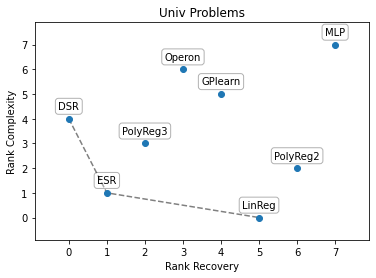

In [281]:
cat_x = 'r2_test'
cat_x = 'recovery'
def_value_x = 0.0
cat_y = 'complexity'
def_value_y = np.inf

# assume lower is better (negate R2, recovery)

regs_present = list(res.keys())
v1 = -np.array([res[regressor_name][cat_x] if cat_x in res[regressor_name] else def_value_x for regressor_name in regs_present])
v2 = np.array([res[regressor_name][cat_y] if cat_y in res[regressor_name] else def_value_y for regressor_name in regs_present])

ranks_x = np.argsort(np.argsort(v1))
ranks_y = np.argsort(np.argsort(v2))


pareto_idxs = get_pareto_idxs(ranks_x, ranks_y)
pareto_idxs = pareto_idxs[np.argsort([ranks_x[i] for i in pareto_idxs])] # sort by x rank (for plotting)

plt.scatter(ranks_x, ranks_y, zorder = 1)
plt.plot([ranks_x[i] for i in pareto_idxs], [ranks_y[i] for i in pareto_idxs], color = 'gray', linestyle = '--', zorder = 0)


# add labels
offset_x = 0.9
offset_y = 0.9
for i in range(len(regs_present)):
    s = reg_names[regs_present[i]]
    x = ranks_x[i]
    y = ranks_y[i] + .3
    ha = 'center'
    va = 'bottom'
    plt.text(s = s, x = x, y = y, ha = ha, va = va, bbox=dict(facecolor='w', edgecolor='black', boxstyle='round', alpha=0.3))
plt.xlim(0-offset_x, len(regs_present)-1+offset_x)
plt.ylim(0-offset_y, len(regs_present)-1+offset_y)
plt.xticks(range(len(regs_present)))
plt.yticks(range(len(regs_present)))

plt.xlabel(f'Rank {crit_names[cat_x]}')
plt.ylabel(f'Rank {crit_names[cat_y]}')
plt.title(f'{ds_name} Problems')


if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/scatterplot_{ds_name}.pdf', bbox_inches = 'tight')

In [283]:
# print a table

regs = list(res.keys())
crits = list(res[regs[0]].keys())


sort_idx = np.argsort([-res[reg]['recovery'] for reg in regs])
regs = [regs[i] for i in sort_idx]

# header
s = '\\begin{tabular}{l' + 'l'*len(crits) + '}'
print(s)
s = ''
for crit in crits:
    s += f'&{crit_names[crit]}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for reg in regs:
    s = reg_names[reg]
    for crit in crits:
        if crit in res[reg]:
            v = res[reg][crit]
            v = np.round(v, 2)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{llllllll}
&Recovery&RMSE Train&RMSE Test&$R^2$ Train&$R^2$ Test&Complexity&Processing Time\\
\toprule
DSR&0.6&0.0&0.01&1.0&1.0&15.9&12.48\\
ESR&0.5&0.0&0.01&1.0&1.0&9.7&1293.63\\
PolyReg3&0.2&0.04&0.06&1.0&0.99&15.0&0.0\\
Operon&0.2&0.0&0.01&1.0&1.0&40.0&3.67\\
GPlearn&0.2&0.1&0.11&1.0&1.0&19.6&9.03\\
LinReg&0.1&0.35&0.3&0.7&0.51&5.0&0.0\\
PolyReg2&0.1&0.14&0.13&0.98&0.96&10.0&0.0\\
MLP&0.0&0.92&0.93&1.0&1.0&-&4.24\\
\end{tabular}


## Experiment: Symbolic vs. Numeric Proximity

Fitness Distance Correlation

Takeaway: Symbolic Measures do not correlate with Numeric Measures

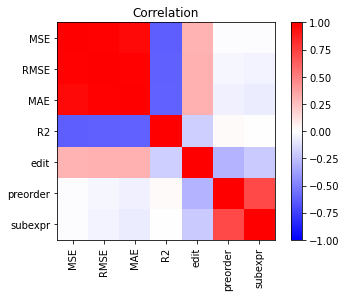

In [83]:
corr_matrix = np.load('results/corr_matrix.npy')
with open(f'results/distance_dict.p', 'rb') as handle:
    dist_dict = pickle.load(handle)
methods = list(dist_dict.keys())


plt.imshow(corr_matrix, vmin = -1, vmax = 1, cmap = 'bwr')
plt.colorbar()
plt.xticks(range(corr_matrix.shape[0]), methods, rotation = 90)
plt.yticks(range(corr_matrix.shape[0]), methods)
plt.title('Correlation')

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig('results/figures/corr_plot.pdf', bbox_inches = 'tight')